## Imports and Helper Functions

In [25]:
!pip install comet_ml
!pip install pytorch-lightning

     |████████████████████████████████| 75 kB 448 kB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 656 kB/s eta 0:00:01
  Using cached urllib3-1.26.15-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uninstalled urllib3-1.26.9
     |████████████████████████████████| 358 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 21.7 MB/s eta 0:00:01
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)


In [26]:
from comet_ml import Experiment
import torch
import os
import random
import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl

from pytorch_lightning.loggers import CometLogger

In [27]:
import sys
sys.path.insert(0, './gaze-track-main/Experiments')

from model import gazetrack_model
from gazetrack_data import gazetrack_dataset

In [28]:
import colorsys
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

def plot_pts(fname, gt, preds, pts, c, title):
    cols = np.zeros((len(gt),3))
    for i in range(len(pts)):
        cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.grid(color='gray', linestyle='dashed')
    plt.scatter(0, 0, marker='*', s=200)
    plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
    plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
    plt.xlabel('distance from the camera at origin in x direction (cm)')
    plt.ylabel('distance from the camera at origin in y direction (cm)')
    plt.axis('equal')

## Load model and weights

In [29]:
f = './converted_00002/train/images/'
# weight_file = 'checkpoint.ckpt'
weight_file = "checkpoints/GoogleCheckpoint_GoogleSplit.ckpt"

print(weight_file)
print('Number of test files: ', len(glob(f+"*.jpg")))

checkpoints/GoogleCheckpoint_GoogleSplit.ckpt
Number of test files:  32


In [30]:
# accounts for CUDA not available
model = gazetrack_model()
if(torch.cuda.is_available()):
    dev = torch.device('cuda:0')
else:
    dev = torch.device('cpu')
    
w = torch.load(weight_file, map_location=dev)['state_dict']
model.load_state_dict(w)
model.to(dev)
model.eval()

preds, gt, ors = [], [], []
ctr = 1
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=8, pin_memory=False, shuffle=False,)

for j in tqdm(test_dataloader):
    leye, reye, kps, target, ori = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev), j[-1]
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)  
    ors.extend(ori)
    
    gt.extend(target.detach().cpu().numpy())
    
preds = np.array(preds)
gt = np.array(gt)
ors = np.array(ors)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

Num files for test = 32


  0%|          | 0/1 [00:09<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x11 and 8x128)

In [ ]:
# assumes cuda available
model = gazetrack_model()
w = torch.load(weight_file)['state_dict']
model.load_state_dict(w)
model.cuda()
model.eval()

preds, gt, ors = [], [], []
ctr = 1
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=8, pin_memory=False, shuffle=False,)

for j in tqdm(test_dataloader):
    leye, reye, kps, target, ori = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda(), j[-1]
    
    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)  
    ors.extend(ori)
    
    gt.extend(target.detach().cpu().numpy())
    
preds = np.array(preds)
gt = np.array(gt)
ors = np.array(ors)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

In [ ]:
print("Portrait orientation: ", np.mean(dist[np.where(ors==2)]))
print("Landscape, with home button on the right: ", np.mean(dist[np.where(ors==1)]))
print("Landscape, with home button on the left: ", np.mean(dist[np.where(ors==0)]))

In [ ]:
import colorsys
import random

def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

c = get_colors(30)
random.shuffle(c)
def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))
    
plt.figure(figsize=(12,12))
plt.title('Modified GazeCaputre All Predictions. Mean Error: '+str(dist.mean())+"cm")
plt.grid(color='gray', linestyle='dashed')

plt.scatter(gt[:,0], gt[:,1],  marker='+', s=100)
plt.scatter(preds[:,0], preds[:,1], s=5)
plt.scatter(0, 0, marker='*', s=200)



plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.axis('scaled')
plt.savefig('GTFull')

NameError: name 'dist' is not defined

<Figure size 1200x1200 with 0 Axes>

## Test Participant Wise

In [31]:
all_files = glob(f+"/*.jpg")
all_files = [i[:-10] for i in all_files]
files = np.unique(all_files)
print('Found ', len(all_files), ' images from ', len(files), ' subjects.')

fnames = []
nums = []
for i in tqdm(files):
    fnames.append(i)
    nums.append(len(glob(i+"*.jpg")))
fnames = np.array(fnames)
nums = np.array(nums)
ids = np.argsort(nums)
ids = ids[::-1]
fnames_sorted = fnames[ids]
nums_sorted = nums[ids]
files = fnames_sorted.copy()
nums_sorted[0], nums_sorted[-1], sum(nums_sorted)

Found  32  images from  1  subjects.


100%|██████████| 1/1 [00:00<00:00, 683.00it/s]


(32, 32, 32)

In [ ]:
total_test = {}

for idx in tqdm(range(len(files))):    
    preds, gt = [], []
    ctr = 1
    f = files[idx]
    test_dataset = gazetrack_dataset(f, phase='test')
    test_dataloader = DataLoader(test_dataset, batch_size=100, num_workers=10, pin_memory=False, shuffle=False,)

    for j in test_dataloader:
        leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

        with torch.no_grad():
            pred = model(leye, reye, kps)
        pred = pred.detach().cpu().numpy()
        preds.extend(pred)  

        gt.extend(target.detach().cpu().numpy())

    preds = np.array(preds)
    pts = np.unique(gt, axis=0)

    gt = np.array(gt)
    dist = euc(preds, gt)
    total_test[f] = [dist, gt, preds, pts]

In [ ]:
mean_errs = []
cols = []
c = get_colors(len(total_test))
random.shuffle(c)
for idx, i in enumerate(total_test):
    mean_errs.extend(total_test[i][0])
    cols.extend([c[idx] for j in range(len(total_test[i][0]))])
    
plt.figure(figsize=(24, 12))
plt.title("Overall Mean Euc Dist: "+str(np.mean(mean_errs)) + "\nOverall Median Euc Dist: "+str(np.median(mean_errs)))
plt.scatter([i for i in range(len(mean_errs))], mean_errs,c=cols, s=5)
plt.hlines(y=np.mean(mean_errs), xmin=0, xmax=len(mean_errs), color='white')
plt.hlines(y=np.median(mean_errs), xmin=0, xmax=len(mean_errs), color='black')
plt.xlabel('Test point id')
plt.ylabel('Mean Euclidean Distance')


## Random Test

device:  iPhone 6
id:  0
Num files:  32
Sample:


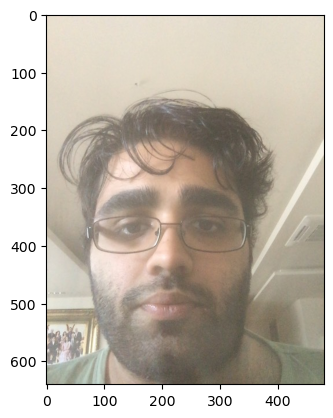

In [32]:
idx = 0
meta = json.load(open(glob(files[idx].replace('images', 'meta')+"*.json")[0]))
print("device: ", meta['device'])
print("id: ", idx)
print("Num files: ", len(glob(files[idx]+"*.jpg")))
print("Sample:")
plt.imshow(plt.imread(glob(files[idx]+"*.jpg")[0]))

In [38]:
import numpy as np
import pandas as pd

# t_np = t.numpy() #convert to Numpy array
# df = pd.DataFrame(t_np) #convert to a dataframe
# df.to_csv("testfile",index=False) #save to file

i = 0
for j in test_dataloader: 
    i += 1
    leye, reye, kps, target = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev)
    
    leye_np = leye.numpy()
    reye_np = reye.numpy()
    kps_np = kps.numpy()
    target_np = target.numpy()
    
    # ============ leye & reye =============
    # red channel
    leye_df1 = pd.DataFrame(leye_np[0][0])
    leye_df1.to_csv("00002_sample_output/leye1.csv", index=False, header = False)

    reye_df1 = pd.DataFrame(reye_np[0][0])
    reye_df1.to_csv("00002_sample_output/reye1.csv", index=False, header = False)

    # green channel
    leye_df2 = pd.DataFrame(leye_np[0][1])
    leye_df2.to_csv("00002_sample_output/leye2.csv", index=False, header = False)

    reye_df2 = pd.DataFrame(reye_np[0][1])
    reye_df2.to_csv("00002_sample_output/reye2.csv", index=False, header = False)

    # blue channel
    leye_df3 = pd.DataFrame(leye_np[0][2])
    leye_df3.to_csv("00002_sample_output/leye3.csv", index=False, header = False)

    reye_df3 = pd.DataFrame(reye_np[0][2])
    reye_df3.to_csv("00002_sample_output/reye3.csv", index=False, header = False)

    # ============ kps =============
    # the 11 values form a column in the dataframe - is that an issue? 
    kps_df = pd.DataFrame(kps_np[0])
    kps_df.to_csv("00002_sample_output/kps.csv", index=False, header = False)

    # ============ target =============
    # the 2 values form a column in the df - is that an issue?
    target_df = pd.DataFrame(target_np[0])
    target_df.to_csv("00002_sample_output/target.csv", index = False, header = False)

    torch.set_printoptions(threshold=-1)
    print("leye: ", leye[0][0])
    print("reye: ", reye[0])
    print("kps: ", kps[0])
    print("target: ", target[0])
    if (i == 1): break

leye:  tensor([[ 7.3734,  7.1774,  6.9813,  ..., 24.8244, 25.0205, 25.2166],
        [ 6.9813,  6.5891,  6.7852,  ..., 25.0205, 25.0205, 25.0205],
        [ 6.7852,  6.3930,  6.7852,  ..., 25.0205, 25.0205, 24.6283],
        ...,
        [ 7.1774,  7.1774,  6.9813,  ..., 27.3734, 27.9617, 28.3538],
        [ 6.1970,  6.0009,  5.8048,  ..., 27.5695, 27.9617, 28.3538],
        [ 6.9813,  6.3930,  6.1970,  ..., 27.7656, 28.1577, 28.7460]])
reye:  tensor([[[ 8.7460,  8.5499,  9.1381,  ...,  9.1381,  9.1381,  8.3538],
         [ 8.9421,  9.1381,  9.7264,  ...,  8.9421,  8.9421,  8.3538],
         [ 9.1381,  9.7264, 10.3146,  ...,  8.3538,  8.3538,  8.1577],
         ...,
         [29.9225, 29.5303, 29.3342,  ..., 22.4715, 22.4715, 22.6675],
         [29.9225, 29.7264, 29.3342,  ..., 22.2754, 22.0793, 21.8832],
         [29.7264, 29.5303, 29.1381,  ..., 22.0793, 21.8832, 21.6872]],

        [[ 5.6984,  5.5024,  6.0906,  ...,  4.7180,  4.7180,  3.9337],
         [ 5.6984,  5.8945,  6.6788,  .

In [37]:
reye_df1

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8.745982,8.549904,9.138139,10.118531,10.902844,11.687159,11.098923,10.118531,9.530295,10.118531,...,8.549904,9.138139,9.334217,8.353826,6.785198,7.177354,8.549904,9.138139,9.138139,8.353826
1,8.942060,9.138139,9.726374,10.314610,10.706766,11.098923,10.706766,9.726374,9.334217,10.314610,...,8.549904,9.334217,9.334217,8.549904,7.177354,7.177354,8.353826,8.942060,8.942060,8.353826
2,9.138139,9.726374,10.314610,10.706766,10.510688,10.510688,10.314610,9.726374,9.530295,10.706766,...,8.942060,9.138139,9.138139,8.745982,7.961668,7.569511,7.961668,8.353826,8.353826,8.157746
3,9.138139,9.922453,10.706766,10.706766,10.314610,10.118531,10.314610,10.314610,9.922453,10.510688,...,9.334217,9.138139,8.942060,8.745982,8.549904,7.961668,7.961668,7.961668,8.157746,7.961668
4,8.942060,10.118531,10.706766,10.706766,10.118531,9.922453,10.510688,10.902844,10.510688,10.510688,...,9.334217,8.942060,8.745982,8.942060,9.138139,8.353826,7.961668,7.765590,7.961668,8.157746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,29.334217,29.138136,29.138136,29.138136,28.942060,28.942060,29.138136,29.138136,29.138136,28.942060,...,25.020493,24.628334,24.040098,23.451864,23.059708,23.059708,23.059708,23.059708,22.863628,22.863628
124,29.530293,29.334217,29.334217,29.334217,29.138136,29.138136,29.138136,29.138136,29.138136,29.138136,...,24.040098,24.040098,23.844021,23.451864,23.255785,22.863628,22.863628,22.863628,22.863628,23.059708
125,29.922451,29.530293,29.334217,29.334217,29.334217,29.138136,29.138136,29.138136,29.138136,29.138136,...,23.647942,23.844021,23.844021,23.451864,23.255785,22.863628,22.667549,22.471472,22.471472,22.667549
126,29.922451,29.726376,29.334217,29.334217,29.138136,29.138136,29.138136,29.334217,29.334217,29.138136,...,23.647942,23.647942,23.647942,23.451864,23.059708,22.471472,22.275393,22.275393,22.079315,21.883236


In [54]:
preds, gt = [], []
ctr = 1
f = files[idx]
fs = glob(f+"*.jpg")
test_dataset = gazetrack_dataset(f, phase='test')
test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

if(torch.cuda.is_available()):
    dev = torch.device('cuda:0')
else:
    dev = torch.device('cpu')

preds, gt = [], []
for j in test_dataloader:
    # leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()
    leye, reye, kps, target = j[1].to(dev), j[2].to(dev), j[3].to(dev), j[4].to(dev)
    print("leye: ", leye[0])
    print("reye: ", reye.shape)
    print("kps: ", kps.shape)
    print("target: ", target.shape)

    with torch.no_grad():
        pred = model(leye, reye, kps)
    pred = pred.detach().cpu().numpy()
    preds.extend(pred)  

    gt.extend(target.detach().cpu().numpy())

preds = np.array(preds)
pts = np.unique(gt, axis=0)

c = get_colors(len(pts))
random.shuffle(c)

gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())
plot_pts(f, gt, preds, pts, c, "Mean euc: "+str(dist.mean()))

Num files for test = 32
leye:  torch.Size([32, 3, 128, 128])
reye:  torch.Size([32, 3, 128, 128])
kps:  torch.Size([32, 11])
target:  torch.Size([32, 2])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x11 and 8x128)